Task 1. Solve classification task (5 points)

Baigazy Maksat

send result here => https://docs.google.com/forms/d/e/1FAIpQLSdSc3Z3LzBkP1g7XsAmp4xlacEYuPPn5iw8yJy0LJHdDx8aKg/viewform?usp=sf_link

In [1]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

1. Data preparation 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name = 'beans', 
    split = ['train', 'validation', 'test'],
    as_supervised = True,
    with_info = True)

2022-10-19 08:16:56.984980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-19 08:16:57.026451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-19 08:16:57.026773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-19 08:16:57.027365: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [4]:
image_height = 500
image_width = 500
num_channels = 3 # RGB
num_classes = 3 # healthy, angular leaf spot disease, bean rust disease

# Pipeline hyperparameters:
batch_size = 32

# Let's keep the dimensions the same (no resizing for now)

def normalize_image(image, label, target_height = 500, target_width = 500):
    """Normalizes images: `unit8` -> `float32` and resizes images
    by keeping the aspect ratio the same without distortion."""
    image = tf.cast(image, tf.float32)/255.
    image = tf.image.resize_with_crop_or_pad(image, target_height, target_width)
    return image, label

ds_train = ds_train.map(normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
ds_validation = ds_validation.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_validation = ds_validation.batch(batch_size)
ds_validation = ds_validation.cache()
ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
from collections import Counter


def return_class_labels(ds):
    """"Returns a list of class labels from a `DatasetV1Adapter` object."""
    l_labels = []
    for _, labels in ds.take(-1):
        labels = labels.numpy()
        l_labels.append(labels[:])
    return [item for sublist in l_labels for item in sublist]

training_labels = return_class_labels(ds_train)
print("The distribution of training labels is: ", (Counter(training_labels)))

validation_labels = return_class_labels(ds_validation)
print("The distribution of validation labels is: ", (Counter(validation_labels)))

test_labels = return_class_labels(ds_test)
print("The distribution of test labels is: ", (Counter(test_labels)))

The distribution of training labels is:  Counter({1: 348, 0: 345, 2: 341})
The distribution of validation labels is:  Counter({1: 45, 2: 44, 0: 44})
The distribution of test labels is:  Counter({0: 43, 1: 43, 2: 42})


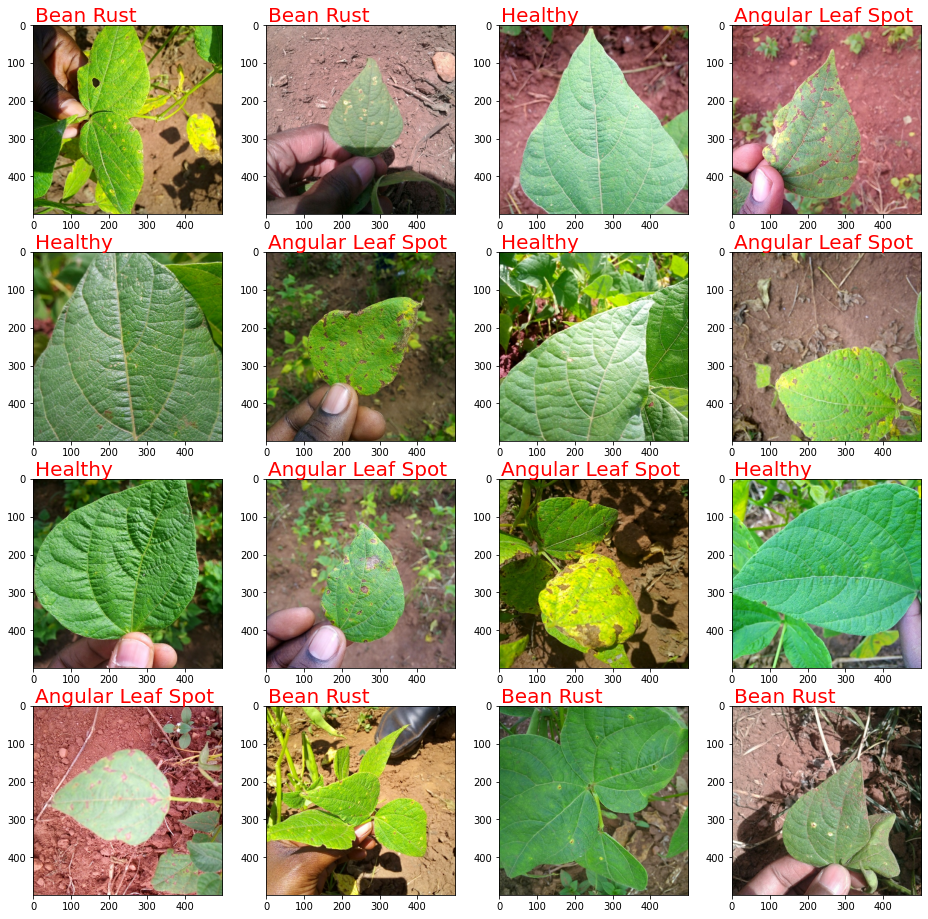

In [7]:
example = ds_train.take(1)
for sample in example:
    image, label = sample[0], sample[1]
    image = image.numpy()
    label = label.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "Angular Leaf Spot" if label[i] == 0 else "Bean Rust" if label[i] == 1 else "Healthy",
            color = 'red', fontsize = 20)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))  

In [8]:
num_filters = 15
filter_size = 10
pool_size = 4
strides = 2
fc_output = 128
drop_probability = 0.25
learning_rate = 0.001

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(num_filters, filter_size, input_shape = (image_height, image_width, 3),
                        strides = strides, padding = 'same', activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Conv2D(num_filters, filter_size, strides = strides, padding = 'same', 
                         activation = 'relu'),
  tf.keras.layers.MaxPooling2D(pool_size = pool_size),
  tf.keras.layers.Dropout(drop_probability),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(fc_output, activation = 'relu'),

  tf.keras.layers.Dense(num_classes, activation = 'softmax'),
])

In [10]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate),
    metrics = ['accuracy'],
)

In [11]:
num_epochs = 20
history = model.fit(
    ds_train,
    epochs = num_epochs,
    validation_data = ds_validation,
)

Epoch 1/20


2022-10-19 08:18:51.481452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-10-19 08:18:53.776386: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-19 08:18:53.778195: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-10-19 08:18:53.778227: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-10-19 08:18:53.778777: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

33/33 [==============================] - 11s 145ms/step - loss: 1.1049 - accuracy: 0.3888 - val_loss: 1.0971 - val_accuracy: 0.3759
Epoch 2/20
33/33 [==============================] - 2s 71ms/step - loss: 1.0943 - accuracy: 0.4120 - val_loss: 1.0754 - val_accuracy: 0.3985
Epoch 3/20
33/33 [==============================] - 2s 70ms/step - loss: 1.1034 - accuracy: 0.3298 - val_loss: 1.0980 - val_accuracy: 0.3383
Epoch 4/20
33/33 [==============================] - 2s 71ms/step - loss: 1.0955 - accuracy: 0.3346 - val_loss: 1.0745 - val_accuracy: 0.3383
Epoch 5/20
33/33 [==============================] - 2s 71ms/step - loss: 1.0592 - accuracy: 0.4449 - val_loss: 1.0787 - val_accuracy: 0.4737
Epoch 6/20
33/33 [==============================] - 2s 69ms/step - loss: 0.9768 - accuracy: 0.5184 - val_loss: 0.9183 - val_accuracy: 0.5188
Epoch 7/20
33/33 [==============================] - 2s 70ms/step - loss: 0.8888 - accuracy: 0.5484 - val_loss: 0.8693 - val_accuracy: 0.6015
Epoch 8/20
33/33 [====

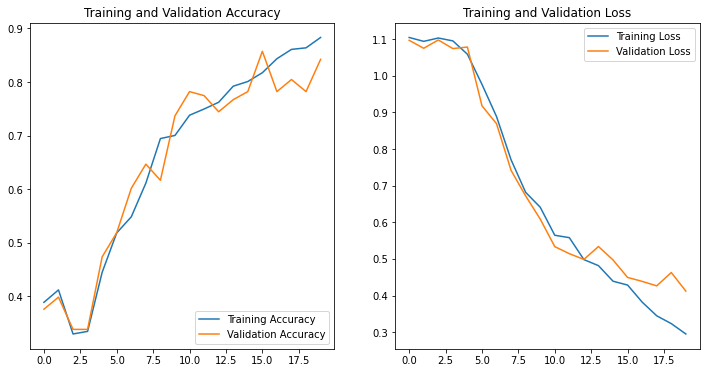

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Baseline accuracy more than 70 for all of classes AND more than 35 for each 

In [13]:
test_loss, test_acc = model.evaluate(ds_test)
print('n Final test accuracy:', test_acc)

4/4 [==============================] - 0s 38ms/step - loss: 0.5478 - accuracy: 0.7891
n Final test accuracy: 0.7890625


Write a function for classification of one image (2 points):
<br> Input: 1 image from dataset
<br> Output: predicted class, target class and comarison 

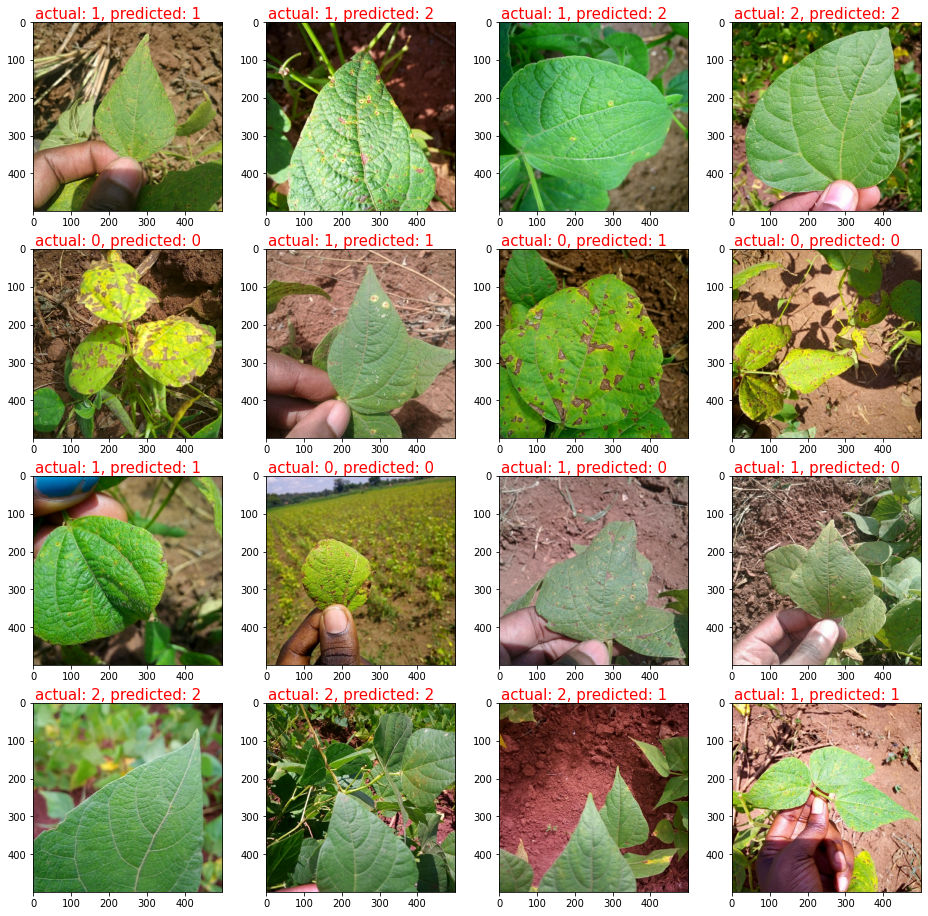

In [14]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
normalized_probs = probability_model.predict(ds_test)
predicted_labels = np.argmax(normalized_probs, axis = 1)
actual_labels = return_class_labels(ds_test)

# Looking at test images
example = ds_test.take(1)
for sample in example:
    image = sample[0]
    image = image.numpy()

n_cols, n_rows = 4, 4
plt.rcParams['figure.figsize'] = [n_cols*4, n_rows*4]

fig = plt.figure()
for i in range(1, n_cols*n_rows + 1):
    ax = fig.add_subplot(n_rows, n_cols,i)
    ax.text(5, -9, "actual: " + str(actual_labels[i]) + ", predicted: " + str(predicted_labels[i]) ,
            color = 'red', fontsize = 15)
    ax.imshow(image[i, :, :, :], cmap = plt.get_cmap("jet"))

Theoretical part (2 points)
<br>1) describe differences between binary cross entropy and categorical cross entropy
<br>2) describe difference between C-means and K-means 

1) Binary cross entropy it's just a special case of the categorical cross entropy. So, when you have only two classes, you can use binary cross entropy, you don't need to do one hot encoding - your code will be couple of the lines less.

2) The difference is that in case of K-means, each element is assigned to only a single cluster, while in case if C-means, being a Fuzzy clustering technique, each element is assigned to all the available clusters with a different membership degree for each cluster.